In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from mpl_toolkits.basemap import Basemap
import datetime as dt
import glob
import os
import pyart
import zipfile
import warnings
warnings.simplefilter("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#TODO:
# -> Fix wind gust spikes in BARRA-R data

barpac = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_access_gusts_1985_2005.pkl").drop_duplicates().set_index(["time","loc_id"]).rename(columns={"max_wndgust10m":"barpac"})
barpac2 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_access_gusts_2039_2058.pkl").drop_duplicates().set_index(["time","loc_id"]).rename(columns={"max_wndgust10m":"barpac2"})
barpac_erai = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_erai_gusts_1990_2015.pkl").drop_duplicates().set_index(["time","loc_id"]).rename(columns={"max_wndgust10m":"barpac_erai"})
barpa_r = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barpa_access_1985_2005.pkl").drop_duplicates().set_index(["time","loc_id"]).rename(columns={"max_wndgust10m":"barpa_r"})
obs = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/obs/aws/all_daily_max_wind_gusts_6hrly_aus_1979_2017.pkl").drop_duplicates().set_index(["daily_date","stn_name"]).rename(columns={"wind_gust":"obs"})
wg_daily = obs.reset_index()
wg_daily["hourly_time_utc"] = pd.DatetimeIndex(obs["gust_time_utc"]).round("H")

barra = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barra_wg10_djf_1990_2005.pkl").drop_duplicates()
barra = barra.set_index("time")[["max_wndgust10m","loc_id"]]
barra = barra[np.in1d(barra.loc_id, barra.reset_index().loc_id.unique())]
temp = pd.DataFrame()
for loc in barra.loc_id.unique():
    temp = pd.concat([temp, barra[barra.loc_id==loc].resample("1D").max()], axis=0)
barra = temp.set_index("loc_id", append=True).rename(columns={"max_wndgust10m":"barra_r"}).dropna()

barpac = barpac[np.in1d(pd.DatetimeIndex(barpac.reset_index().time).month, [12,1,2])]
barpac2 = barpac2[np.in1d(pd.DatetimeIndex(barpac2.reset_index().time).month, [12,1,2])]
barpac_erai = barpac_erai[np.in1d(pd.DatetimeIndex(barpac_erai.reset_index().time).month, [12,1,2])]
barpa_r = barpa_r[np.in1d(pd.DatetimeIndex(barpa_r.reset_index().time).month, [12,1,2])]
barra = barra[np.in1d(pd.DatetimeIndex(barra.reset_index().time).month, [12,1,2])]
obs = obs[np.in1d(pd.DatetimeIndex(obs.reset_index().daily_date).month, [12,1,2])]

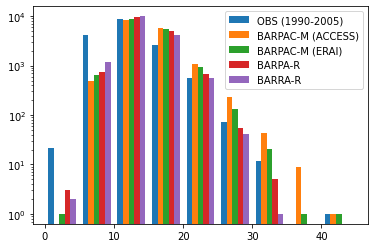

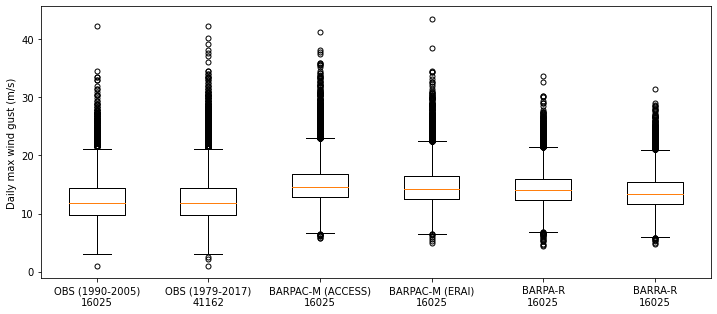

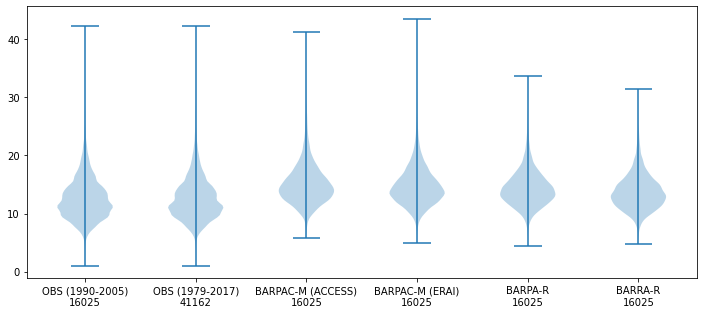

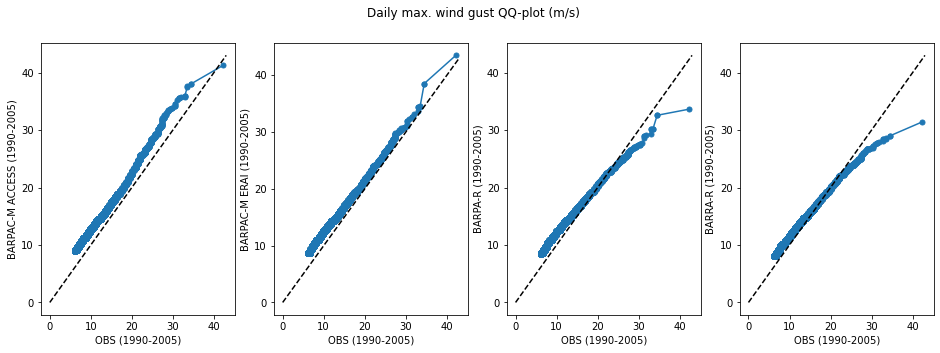

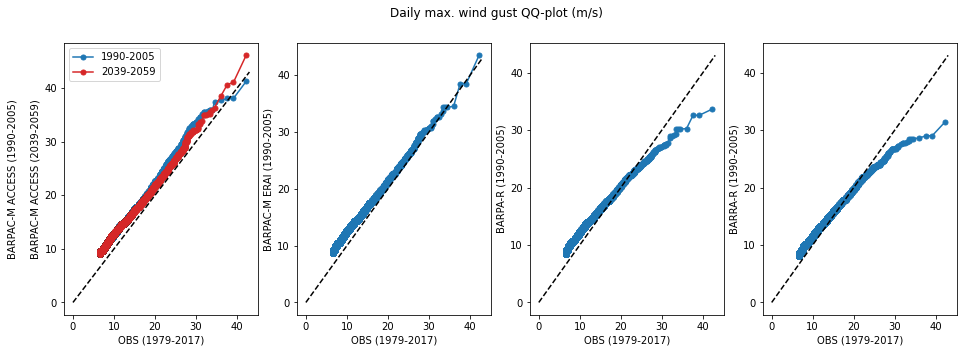

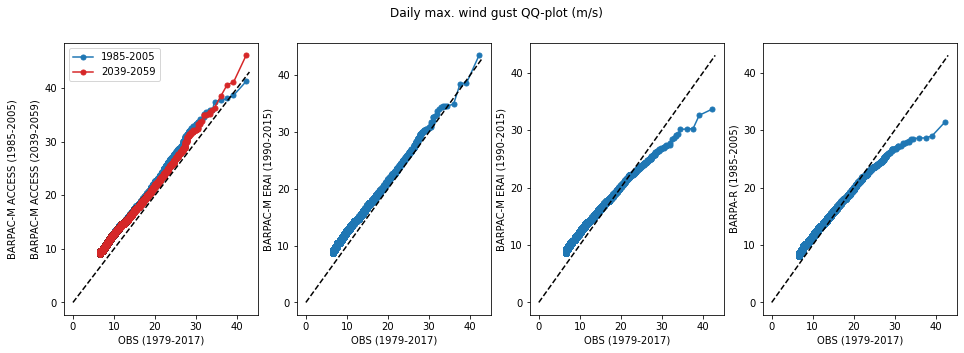

In [3]:
#DF: 0) Obs 1) BARPAC (ACCESS) 2) BARPAC (ERAI) 3) BARPA-R 4) BARRA-R

#HISTOGRAM
merged = pd.concat([barpa_r,barpac,barpac_erai,barra,obs], axis=1, join="inner").dropna()[["obs","barpac","barpac_erai","barpa_r","barra_r"]]
plt.hist(merged.values, log=True, label=["OBS (1990-2005)","BARPAC-M (ACCESS)","BARPAC-M (ERAI)","BARPA-R","BARRA-R"], bins=np.arange(0,50,5))
plt.legend()

#BOXPLOT
plt.figure(figsize=[12,5])
temp=obs.reset_index()
temp=temp.loc[(np.in1d(temp.stn_name, barpac.reset_index().loc_id.unique())) & (np.in1d(temp.month,[12,1,2]))].dropna()
plt.boxplot([merged.values[:,0],temp["obs"].values,merged.values[:,1],merged.values[:,2],merged.values[:,3],merged.values[:,4]], labels=["OBS (1990-2005)\n"+str(merged.shape[0]),"OBS (1979-2017)\n"+str(temp.shape[0]),"BARPAC-M (ACCESS)\n"+str(merged.shape[0]),"BARPAC-M (ERAI)\n"+str(merged.shape[0]),"BARPA-R\n"+str(merged.shape[0]),"BARRA-R\n"+str(merged.shape[0])], flierprops={"ms":5})
plt.ylabel("Daily max wind gust (m/s)")

#VIOLIN PLOT
plt.figure(figsize=[12,5])
ax=plt.gca()
plt.violinplot([merged.values[:,0],temp["obs"].values,merged.values[:,1],merged.values[:,2],merged.values[:,3],merged.values[:,4]], )
labels=["OBS (1990-2005)\n"+str(merged.shape[0]),"OBS (1979-2017)\n"+str(temp.shape[0]),"BARPAC-M (ACCESS)\n"+str(merged.shape[0]),"BARPAC-M (ERAI)\n"+str(merged.shape[0]),"BARPA-R\n"+str(merged.shape[0]),"BARRA-R\n"+str(merged.shape[0])]
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)

#QQ-PLOT (SHORT OBS)
label=["OBS (1990-2005)","BARPAC-M ACCESS (1990-2005)","BARPAC-M ERAI (1990-2005)","BARPA-R (1990-2005)","BARRA-R (1990-2005)","OBS (1979-2017)"]
plt.figure(figsize=[16,5])
plt.suptitle("Daily max. wind gust QQ-plot (m/s)")
plt.subplot(1,4,1)
#p=np.percentile(merged,np.linspace(0,100,100000), axis=0)
p=np.percentile(merged,np.logspace(0,2,100000), axis=0, interpolation="nearest")
plt.plot(p[:,0], p[:,1], marker="o", ms=5); plt.ylabel(label[1]); plt.xlabel(label[0])
plt.plot([0,43],[0,43], "k--")
plt.subplot(1,4,2)
plt.plot(p[:,0], p[:,2], marker="o", ms=5); plt.ylabel(label[2]); plt.xlabel(label[0])
plt.plot([0,43],[0,43], "k--")
plt.subplot(1,4,3)
plt.plot(p[:,0], p[:,3], marker="o", ms=5); plt.ylabel(label[3]); plt.xlabel(label[0])
plt.plot([0,43],[0,43], "k--")
plt.subplot(1,4,4)
plt.plot(p[:,0], p[:,4], marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[4]); plt.xlabel(label[0])

#QQ-PLOT (1979-2017 obs and 1990-2005 model quantiles)
label=["OBS (1990-2005)","BARPAC-M ACCESS (1990-2005)\n\nBARPAC-M ACCESS (2039-2059)","BARPAC-M ERAI (1990-2005)","BARPA-R (1990-2005)","BARRA-R (1990-2005)","OBS (1979-2017)"]
plt.figure(figsize=[16,5])
plt.suptitle("Daily max. wind gust QQ-plot (m/s)")
plt.subplot(1,4,1)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), p[:,1], marker="o", ms=5, label="1990-2005")
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barpac2["barpac2"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5, color="tab:red", label="2039-2059")
plt.legend()
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[1]); plt.xlabel(label[5])
plt.subplot(1,4,2)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), p[:,2], marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[2]); plt.xlabel(label[5])
plt.subplot(1,4,3)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), p[:,3], marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[3]); plt.xlabel(label[5])
plt.subplot(1,4,4)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), p[:,4], marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[4]); plt.xlabel(label[5])

#QQ-PLOT (1979-2017 obs and model quantiles using all years)
label=["OBS (1990-2005)","BARPAC-M ACCESS (1985-2005)\n\nBARPAC-M ACCESS (2039-2059)","BARPAC-M ERAI (1990-2015)","BARPA-R (1985-2005)","BARRA-R (1990-2005)","OBS (1979-2017)"]
plt.figure(figsize=[16,5])
plt.suptitle("Daily max. wind gust QQ-plot (m/s)")
plt.subplot(1,4,1)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barpac["barpac"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5, label="1985-2005")
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barpac2["barpac2"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5, color="tab:red", label="2039-2059")
plt.legend()
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[1]); plt.xlabel(label[5])
plt.subplot(1,4,2)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barpac_erai["barpac_erai"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[2]); plt.xlabel(label[5])
plt.subplot(1,4,3)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barpa_r["barpa_r"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[2]); plt.xlabel(label[5])
plt.subplot(1,4,4)
plt.plot(np.percentile(temp["obs"].values,np.logspace(0,2,100000), interpolation="nearest"), np.percentile(barra["barra_r"].values,np.logspace(0,2,100000), interpolation="nearest"), marker="o", ms=5)
plt.plot([0,43],[0,43], "k--"); plt.ylabel(label[3]); plt.xlabel(label[5])

plt.savefig("/g/data/eg3/ab4502/figs/barpa/barpac_wg.png")

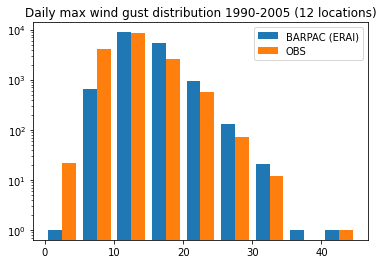

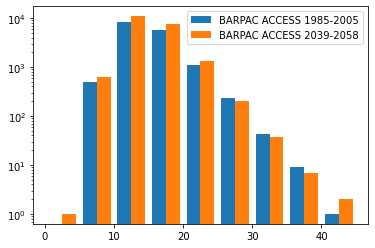

In [4]:
#Note that 25 m/s in obs corresponds to 99.5th percentile of daily gusts; equivalent gust in BARPAC-M at these 12 locations is 28.5 m/s

a,b,c=plt.hist(merged[["barpac_erai","obs"]].values, bins=np.arange(0,50,5), log=True, label=["BARPAC (ERAI)","OBS"])
plt.legend()
plt.title("Daily max wind gust distribution 1990-2005 (12 locations)")

plt.figure()
plt.hist([merged["barpac"].values, barpac2["barpac2"].values], bins=np.arange(0,50,5), log=True, label=["BARPAC ACCESS 1985-2005","BARPAC ACCESS 2039-2058"])
plt.legend()

In [5]:
#Highest observed gusts 1990-2005 at 12 locations
top_obs = pd.concat([barpac_erai,obs], axis=1, join="inner").dropna().sort_values("obs")[["lat","lon","barpac_erai","obs"]].iloc[-5:]
top_obs

,,lat,lon,barpac_erai,obs
1995-01-01,Cobar,-31.4840,145.8294,13.742188,34.5
2009-01-22,Hobart,-42.8897,147.3278,23.218750,34.5
2014-02-09,Hobart,-42.8897,147.3278,22.603516,36.0
2010-12-07,Woomera,-31.1558,136.8054,19.716797,37.6
1998-12-27,East Sale,-38.1156,147.1322,23.708984,42.2


In [6]:
#Highest modelled gusts 1990-2005 at 12 locations
top_mod=pd.concat([barpac_erai,obs], axis=1, join="inner").dropna().sort_values("barpac_erai")[["lat","lon","barpac_erai","obs"]].iloc[-5:]
top_mod

,,lat,lon,barpac_erai,obs
2009-12-17,Wagga Wagga,-35.1583,147.4575,34.931641,27.8
2008-12-18,Coffs Harbour,-30.3107,153.1187,36.361328,15.9
1999-12-15,Mildura,-34.2358,142.0867,38.538086,18.0
2008-01-11,Melbourne,-37.6655,144.8321,38.555664,19.5
1998-02-26,Melbourne,-37.6655,144.8321,43.507812,31.9


In [40]:
#TODO:
#Write code that takes the date, lat and lon of the above dataframe (for N 
# highest model gusts), finds the time of highest gust from BARPAC data on that date, 
# loads BARPA-R convective diagnostic data for that date/time, and plots a
# spatial map of a diagnostic, as well as a spatial map of the 10-minute wind gust

    
#TODO
#-> Load/plot convective inds (maps at multiple times, time series)
#-> Plot point on map
#-> Options to plot multiple 10-minute time steps

#TODO
#-> Add functionality to open_wgfile() to use the time of daily max AWS gust to get BARPAC maps, instead of time of maximum model gust.
    

def open_wgfile(time, lon, lat, wg_df, wg_daily, loc, time_max="model", model_delta_t=0):
    #For a given time (datetime object), extract a time series at lon, lat. Return the indexed time series, as well as the 2d wg map at the maximum gust time.
    #->time: datetime object for day of interest
    #->lon: spatial point of interest (longitude float)
    #->lat: spatial point of interest (latitude float)
    #->wg_df: half-hourly AWS gust dataframe, loaded in earlier
    #->wg_daily: daily AWS gust dataframe, loaded in earlier
    #->loc: location string, corresponding to lat, lon; must appear in wg_df and wg_daily dataframes
    #->time_max: either "model" or "obs". This will extract spatial maps at either the time of maximum model gust or observed daily max gust
    #->model_delta_t: if not getting maps for maximum model gust time, add a delta_t (minutes) relative to the observed max gust time

    print(time,lon,lat)
    
    wg_obs = wg_df[wg_df.stn_name==loc].set_index("time").loc[slice(time,time+dt.timedelta(days=1))]
    
    wg_files = np.sort(glob.glob("/g/data/du7/barpa/trials/BARPAC-M_km2p2/era/erai/r0/*/*/pp26/max_wndgust10m*.nc"))
    file_dates = [fname.split("/")[-1].split("-")[-1][:-4] for fname in wg_files]
    f = xr.open_dataset(wg_files[np.in1d(np.array(file_dates),time.strftime("%Y%m%dT0000"))][0])
    ts = pd.DataFrame({"gust":f["max_wndgust10m"].interp({"longitude":lon, "latitude":lat},method="nearest")}, index=f.time.values)
    
    if time_max=="model":
        wg_map = f["max_wndgust10m"].isel({"time":(ts["gust"].reset_index()["gust"]).idxmax()})
        reg = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_erai/barpa_erai_"+time.strftime("%Y%m")+"*", combine="by_coords").\
            interp({"time":pd.DatetimeIndex(ts.idxmax().values)[0]}, method="nearest")
    elif time_max=="obs":
        wg_daily = wg_daily[wg_daily.stn_name==loc].set_index("daily_date_utc").sort_values("obs").loc[time]
        if wg_daily.ndim > 1:
            wg_daily=wg_daily.iloc[-1]
        wg_map = f["max_wndgust10m"].interp({"time":wg_daily["hourly_time_utc"] + dt.timedelta(minutes=model_delta_t)},method="nearest")
        reg = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_erai/barpa_erai_"+time.strftime("%Y%m")+"*", combine="by_coords").\
            interp({"time":wg_daily["hourly_time_utc"] + dt.timedelta(minutes=model_delta_t)}, method="nearest")
        
    reg_ts = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_erai/barpa_erai_"+time.strftime("%Y%m")+"*", combine="by_coords").\
        interp({"lat":lat,"lon":lon}, method="nearest").sel({"time":slice(time,time+dt.timedelta(days=1))})
    
    
    return ts, wg_map, reg, reg_ts, wg_obs

def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    
    time = time + dt.timedelta(minutes=radar_t_delta)
    
    isfile = len(glob.glob("/g/data/eg3/ab4502/radar/"+rid+"_"+time.strftime("%Y%m%d")+"*")) > 0
    
    if not isfile:
        print("INFO: UNPACKING RADAR FILE FOR ID "+rid+" AND TIME "+time.strftime("%Y%m%d"))
        path_to_zip_file = "/g/data/rq0/level_1/odim_pvol/"+rid+"/"+str(time.year)+"/vol/"+rid+"_"+time.strftime("%Y%m%d")+".pvol.zip"
        directory_to_extract_to = "/g/data/eg3/ab4502/radar/"
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(directory_to_extract_to)
        
    else:
        print("INFO: LOADING RADAR FILE FOR ID "+rid+" AND TIME "+time.strftime("%Y%m%d"))
        
    files = glob.glob("/g/data/eg3/ab4502/radar/"+rid+"_"+time.strftime("%Y%m%d")+"*")
    f_times = [fname.split("/")[-1].split("_")[2].split(".")[0] for fname in files]
    radar_file=pyart.aux_io.read_odim_h5(\
                              files[np.argmin(np.array([abs(time-dt.datetime(time.year,time.month,time.day,int(f[0:2]),int(f[2:4]),int(f[4:6]))) for f in f_times]))],\
                              file_field_names=True)
    return radar_file
            
            
def plot(r, r_ts, c_map, c_ts, rvar, rdomain, cdomain, slat, slon, wg_loc, rvar_lims=[None,None], rvar_cbar_lims=[None,None], radar=False, rid=None, rsweep=1, radar_t_delta=0):
    rm = Basemap(resolution="i",llcrnrlat=rdomain[0],urcrnrlat=rdomain[1],llcrnrlon=rdomain[2],urcrnrlon=rdomain[3])
    cm = Basemap(resolution="i",llcrnrlat=cdomain[0],urcrnrlat=cdomain[1],llcrnrlon=cdomain[2],urcrnrlon=cdomain[3])
    plt.figure(figsize=[14,10])
    
    #Plot regional model variable "rvar"
    plt.subplot(2,2,1)
    r[rvar].plot(cmap=plt.get_cmap("Reds"), robust=True,vmin=rvar_cbar_lims[0],vmax=rvar_cbar_lims[1])
    rm.drawcoastlines()
    rm.plot(slon,slat,latlon=True,ls="none",marker="x",mew=3,ms=10)
    
    #Plot convection permitting gust map
    plt.subplot(2,2,2)
    c_map.plot(cmap=plt.get_cmap("Reds"))
    cm.plot(slon,slat,latlon=True,ls="none",marker="x",mew=3,ms=10)
    try:
        cm.drawcoastlines()
    except:
        pass
    
    #Plot convection permitting gust time series with diagnostic
    ax=plt.subplot(2,2,3)    
    ax2=ax.twinx()
    l1=c_ts.plot(ax=ax,label="BARPA gust")
    l2=wg_loc["wind_gust"].plot(ax=ax, color="k", ls="--",label="Obs gust 30 min")
    l3=r_ts[rvar].plot(ax=ax2,color="tab:orange",marker="x",label="BARPA-R large-scale")
    try:
        ax2.set_ylim(rvar_lims)
    except:
        pass
    ax.legend(loc=2)
    ax2.legend(loc=1)
    
    #Plot radar
    if radar:
        plt.subplot(2,2,4)
        rfile = load_radar(rid, pd.DatetimeIndex(c_ts.idxmax().values)[0], radar_t_delta=radar_t_delta)
        disp=pyart.graph.RadarMapDisplayBasemap(rfile)
        disp.plot_ppi_map("DBZH",rsweep,cmap=pyart.graph.cm_colorblind.HomeyerRainbow, resolution="i")
        disp.basemap.plot(slon,slat,latlon=True,ls="none",marker="x",mew=3,ms=10)        
    plt.subplots_adjust(hspace=0.3)
        
def read_aws_half_hourly():

        #Read AWS half hourly data

        #Set csv column names
        names = ["record_id","stn_no","stn_name","locality", "state","lat","lon","height","date_str",\
                "wind_dir","wind_dir_quality","wind_gust","quality","aws_flag","eof"]

        #Dict to map station names to
        renames = {'ALICE SPRINGS AIRPORT                   ':"Alice Springs",\
                        'GILES METEOROLOGICAL OFFICE             ':"Giles",\
                        'COBAR MO                                ':"Cobar",\
                        'AMBERLEY AMO                            ':"Amberley",\
                        'SYDNEY AIRPORT AMO                      ':"Sydney",\
                        'MELBOURNE AIRPORT                       ':"Melbourne",\
                        'MACKAY M.O                              ':"Mackay",\
                        'WEIPA AERO                              ':"Weipa",\
                        'MOUNT ISA AERO                          ':"Mount Isa",\
                        'ESPERANCE                               ':"Esperance",\
                        'ADELAIDE AIRPORT                        ':"Adelaide",\
                        'CHARLEVILLE AERO                        ':"Charleville",\
                        'CEDUNA AMO                              ':"Ceduna",\
                        'OAKEY AERO                              ':"Oakey",\
                        'WOOMERA AERODROME                       ':"Woomera",\
                        'TENNANT CREEK AIRPORT                   ':"Tennant Creek",\
                        'GOVE AIRPORT                            ':"Gove",\
                        'COFFS HARBOUR MO                        ':"Coffs Harbour",\
                        'MEEKATHARRA AIRPORT                     ':"Meekatharra",\
                        'HALLS CREEK METEOROLOGICAL OFFICE       ':"Halls Creek",\
                        'ROCKHAMPTON AERO                        ':"Rockhampton",\
                        'MOUNT GAMBIER AERO                      ':"Mount Gambier",\
                        'PERTH AIRPORT                           ':"Perth",\
                        'WILLIAMTOWN RAAF                        ':"Williamtown",\
                        'CARNARVON AIRPORT                       ':"Carnarvon",\
                        'KALGOORLIE-BOULDER AIRPORT              ':"Kalgoorlie",\
                        'DARWIN AIRPORT                          ':"Darwin",\
                        'CAIRNS AERO                             ':"Cairns",\
                        'MILDURA AIRPORT                         ':"Mildura",\
                        'WAGGA WAGGA AMO                         ':"Wagga Wagga",\
                        'BROOME AIRPORT                          ':"Broome",\
                        'EAST SALE                               ':"East Sale",\
                        'TOWNSVILLE AERO                         ':"Townsville",\
                        'HOBART (ELLERSLIE ROAD)                 ':"Hobart",\
                        'PORT HEDLAND AIRPORT                    ':"Port Hedland"}

        #Set csv read data types
        data_types = dict(record_id=str, stn_no=int, stn_name=str, locality=str, state=str, lat=float, lon=float,\
                                district=str, height=str, date_str=str, closest_date_str=str,\
                                wind_gust=float, quality=str, \
                                wind_dir=str, wind_dir_quality=str, max_gust_str_lt=str, max_gust_time_quality=str,\
                                eof=str,aws_flag=str)

        #Read csv
        fname = "/g/data/eg3/ab4502/ExtremeWind/obs/aws/aws_half_hour_aus_2005_2015/HM01X_Data_999999999678486.txt"
        aws = pd.read_csv(fname,header=0,names=names)
        aws.loc[:,"wind_gust"] = pd.to_numeric(aws["wind_gust"], errors="coerce")
        aws["wind_dir"] = pd.to_numeric(aws.wind_dir, errors="coerce")
        aws["time"] =pd.to_datetime(aws.date_str, format="%d/%m/%Y %H:%M")
        aws = aws[["stn_name","time","wind_dir","wind_gust"]]
        aws = aws.replace({"stn_name":renames})
        aws["wind_gust"] = aws["wind_gust"] / 3.6

        return aws

In [8]:
wg_obs = read_aws_half_hourly()

lat            -37.665500
lon            144.832100
barpac_erai     43.507812
obs             31.900000
Name: (1998-02-26 00:00:00, Melbourne), dtype: float64
1998-02-26 00:00:00 144.8321 -37.6655


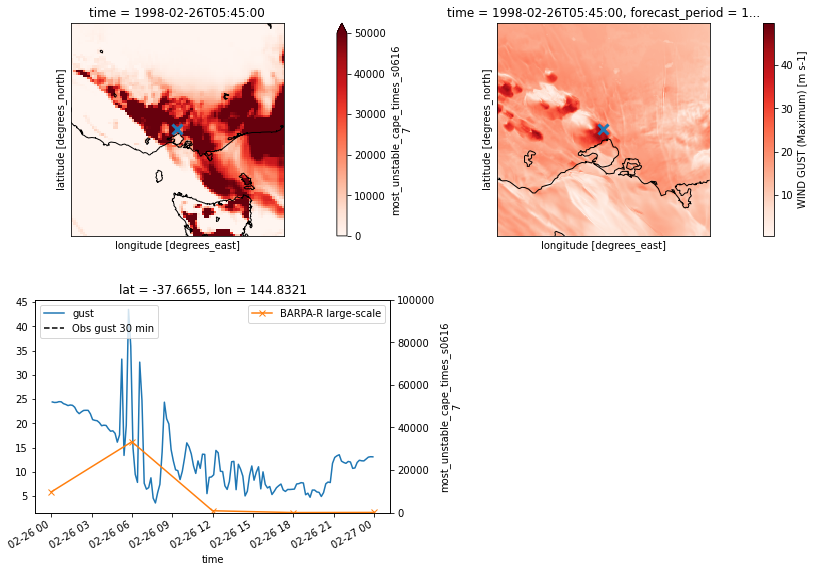

In [9]:
ind=-1
print(top_mod.iloc[ind])
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_mod.reset_index().level_0.values)[ind], top_mod["lon"].iloc[ind], top_mod["lat"].iloc[ind], wg_obs, obs, top_mod.reset_index().level_1.values[ind])        
        
rllbox = 5; cllbox = 2;
rdomain = [top_mod["lat"].iloc[ind]-rllbox, top_mod["lat"].iloc[ind]+rllbox, top_mod["lon"].iloc[ind]-rllbox, top_mod["lon"].iloc[ind]+rllbox]
cdomain = [top_mod["lat"].iloc[ind]-cllbox, top_mod["lat"].iloc[ind]+cllbox, top_mod["lon"].iloc[ind]-cllbox, top_mod["lon"].iloc[ind]+cllbox]

plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_mod["lat"].iloc[ind], top_mod["lon"].iloc[ind],wg_loc,radar=False,rvar_cbar_lims=[0,50000],rvar_lims=[0,100000])

lat            -37.665500
lon            144.832100
barpac_erai     38.555664
obs             19.500000
Name: (2008-01-11 00:00:00, Melbourne), dtype: float64
2008-01-11 00:00:00 144.8321 -37.6655
INFO: LOADING RADAR FILE FOR ID 02 AND TIME 20080111


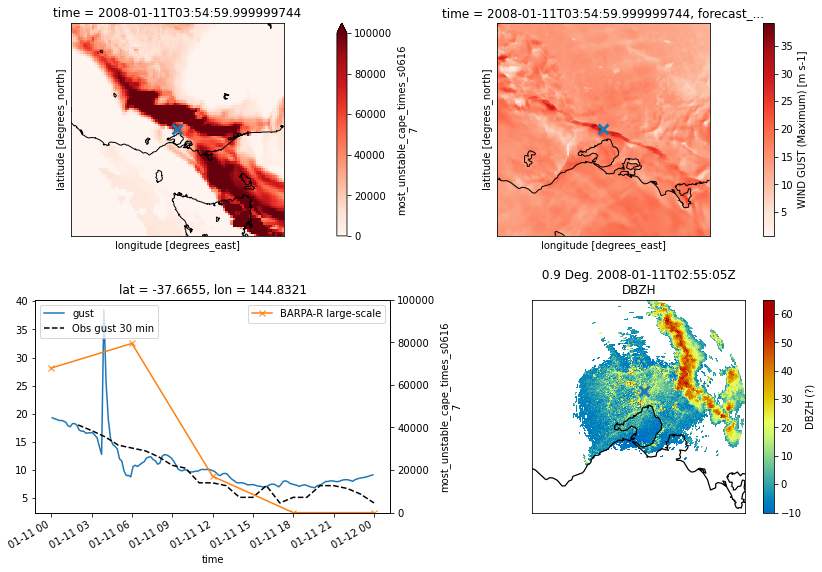

In [43]:
ind=-2
print(top_mod.iloc[ind])
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_mod.reset_index().level_0.values)[ind], top_mod["lon"].iloc[ind], top_mod["lat"].iloc[ind], wg_obs, wg_daily, top_mod.reset_index().level_1.values[ind])        
        
rllbox = 5; cllbox = 2;
rdomain = [top_mod["lat"].iloc[ind]-rllbox, top_mod["lat"].iloc[ind]+rllbox, top_mod["lon"].iloc[ind]-rllbox, top_mod["lon"].iloc[ind]+rllbox]
cdomain = [top_mod["lat"].iloc[ind]-cllbox, top_mod["lat"].iloc[ind]+cllbox, top_mod["lon"].iloc[ind]-cllbox, top_mod["lon"].iloc[ind]+cllbox]

rid="02"; rsweep=1; radar_t_delta=-60
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_mod["lat"].iloc[ind], top_mod["lon"].iloc[ind],wg_loc,rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,100000],rvar_cbar_lims=[0,100000])

lat            -34.235800
lon            142.086700
barpac_erai     38.538086
obs             18.000000
Name: (1999-12-15 00:00:00, Mildura), dtype: float64
1999-12-15 00:00:00 142.0867 -34.2358


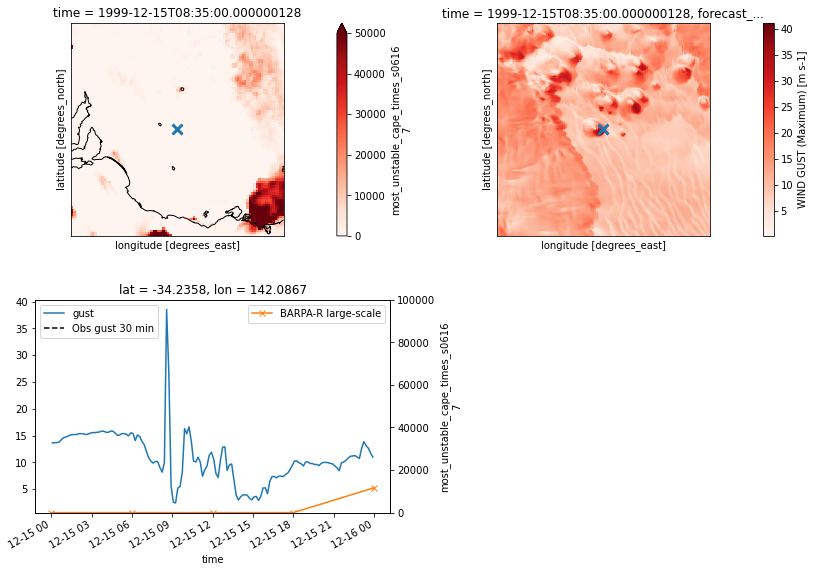

In [11]:
ind=-3
print(top_mod.iloc[ind])
ts,wg_map,reg, reg_ts, wg_loc = open_wgfile(pd.DatetimeIndex(top_mod.reset_index().level_0.values)[ind], top_mod["lon"].iloc[ind], top_mod["lat"].iloc[ind], wg_obs, wg_daily, top_mod.reset_index().level_1.values[ind])        
        
rllbox = 5; cllbox = 2;
rdomain = [top_mod["lat"].iloc[ind]-rllbox, top_mod["lat"].iloc[ind]+rllbox, top_mod["lon"].iloc[ind]-rllbox, top_mod["lon"].iloc[ind]+rllbox]
cdomain = [top_mod["lat"].iloc[ind]-cllbox, top_mod["lat"].iloc[ind]+cllbox, top_mod["lon"].iloc[ind]-cllbox, top_mod["lon"].iloc[ind]+cllbox]

rid="30"
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_mod["lat"].iloc[ind], top_mod["lon"].iloc[ind],wg_loc,radar=False,rid=rid,rvar_lims=[0,100000],rvar_cbar_lims=[0,50000])

lat            -30.310700
lon            153.118700
barpac_erai     36.361328
obs             15.900000
Name: (2008-12-18 00:00:00, Coffs Harbour), dtype: float64
2008-12-18 00:00:00 153.1187 -30.3107
INFO: LOADING RADAR FILE FOR ID 28 AND TIME 20081218


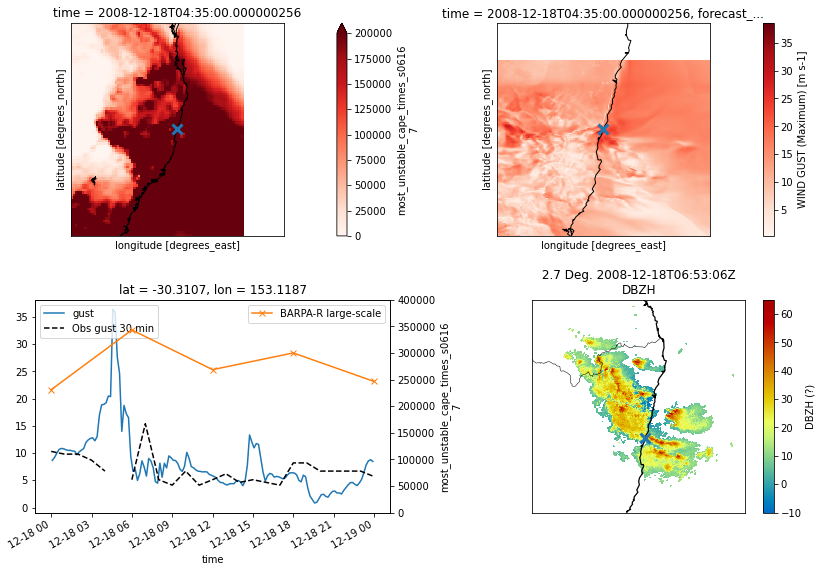

In [12]:
ind=-4
print(top_mod.iloc[ind])
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_mod.reset_index().level_0.values)[ind], top_mod["lon"].iloc[ind], top_mod["lat"].iloc[ind], wg_obs, wg_daily, top_mod.reset_index().level_1.values[ind])        
        
rllbox = 5; cllbox = 2;
rdomain = [top_mod["lat"].iloc[ind]-rllbox, top_mod["lat"].iloc[ind]+rllbox, top_mod["lon"].iloc[ind]-rllbox, top_mod["lon"].iloc[ind]+rllbox]
cdomain = [top_mod["lat"].iloc[ind]-cllbox, top_mod["lat"].iloc[ind]+cllbox, top_mod["lon"].iloc[ind]-cllbox, top_mod["lon"].iloc[ind]+cllbox]

rid="28"; rsweep=1; radar_t_delta=140
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_mod["lat"].iloc[ind], top_mod["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,400000],rvar_cbar_lims=[0,200000])

2009-12-17 00:00:00 147.4575 -35.1583
INFO: LOADING RADAR FILE FOR ID 40 AND TIME 20091217


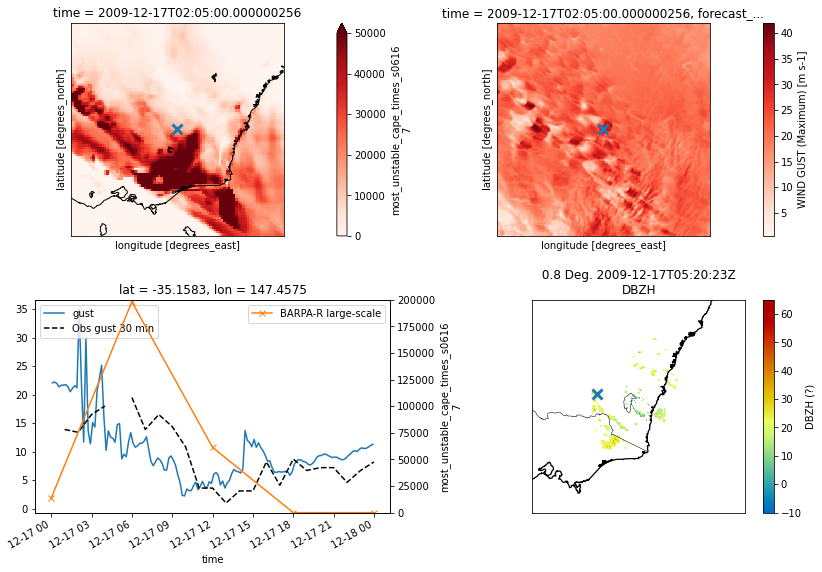

In [13]:
ind=-5
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_mod.reset_index().level_0.values)[ind], top_mod["lon"].iloc[ind], top_mod["lat"].iloc[ind], wg_obs, wg_daily, top_mod.reset_index().level_1.values[ind])        
        
rllbox = 5; cllbox = 2;
rdomain = [top_mod["lat"].iloc[ind]-rllbox, top_mod["lat"].iloc[ind]+rllbox, top_mod["lon"].iloc[ind]-rllbox, top_mod["lon"].iloc[ind]+rllbox]
cdomain = [top_mod["lat"].iloc[ind]-cllbox, top_mod["lat"].iloc[ind]+cllbox, top_mod["lon"].iloc[ind]-cllbox, top_mod["lon"].iloc[ind]+cllbox]

rid="40"; rsweep=1; radar_t_delta=200
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_mod["lat"].iloc[ind], top_mod["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,200000],rvar_cbar_lims=[0,50000])

In [14]:
#TODO
#Map occurrence of 28 m/s in BARPAC and 25 m/s in observatons in terms of monthly/diurnal cycle and inter-annual cycle. Map future changes of 28 m/s occurrences in BARPAC-M

1998-12-27 00:00:00 147.1322 -38.1156


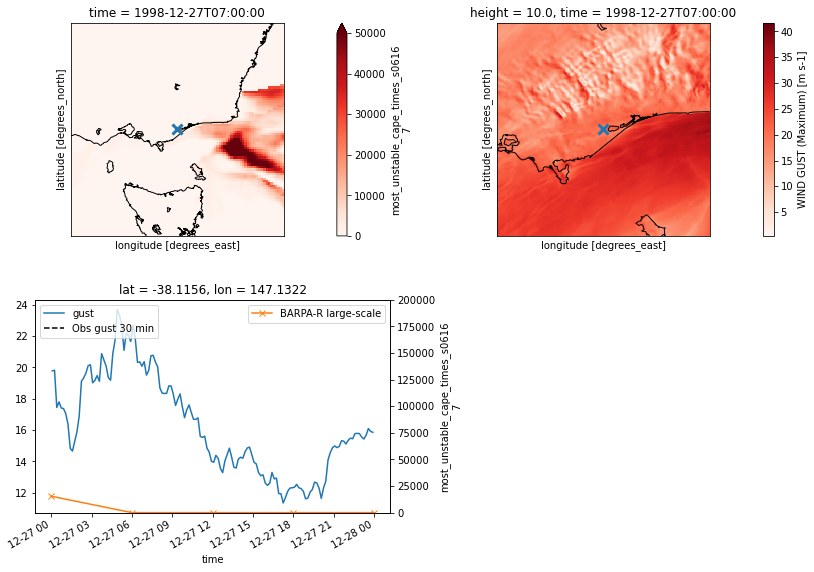

In [27]:
ind=-1
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_obs.reset_index().level_0.values)[ind], top_obs["lon"].iloc[ind], top_obs["lat"].iloc[ind], wg_obs, wg_daily, top_obs.reset_index().level_1.values[ind], time_max="obs")        
        
rllbox = 5; cllbox = 2;
rdomain = [top_obs["lat"].iloc[ind]-rllbox, top_obs["lat"].iloc[ind]+rllbox, top_obs["lon"].iloc[ind]-rllbox, top_obs["lon"].iloc[ind]+rllbox]
cdomain = [top_obs["lat"].iloc[ind]-cllbox, top_obs["lat"].iloc[ind]+cllbox, top_obs["lon"].iloc[ind]-cllbox, top_obs["lon"].iloc[ind]+cllbox]

rid="02"; rsweep=1; radar_t_delta=0
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_obs["lat"].iloc[ind], top_obs["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=False,radar_t_delta=radar_t_delta,rvar_lims=[0,200000],rvar_cbar_lims=[0,50000])

2010-12-07 00:00:00 136.8054 -31.1558
INFO: LOADING RADAR FILE FOR ID 27 AND TIME 20101207


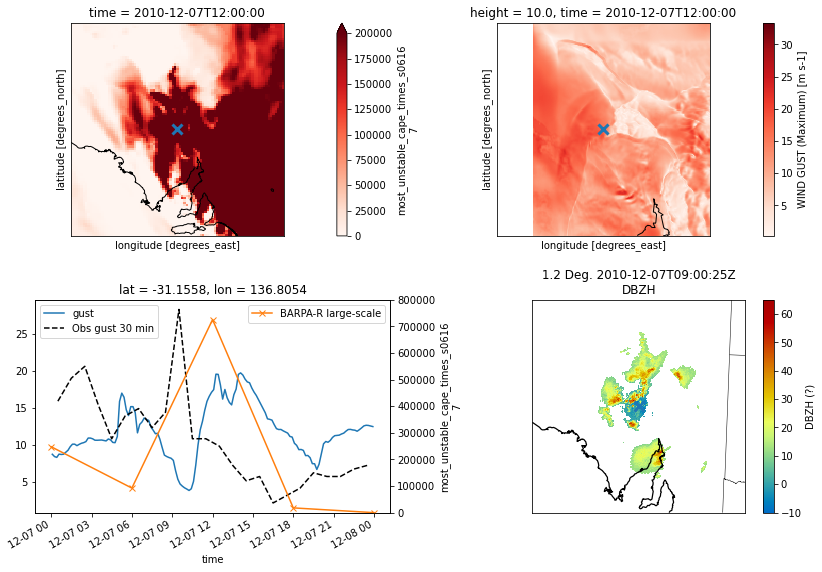

In [58]:
ind=-2
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_obs.reset_index().level_0.values)[ind], top_obs["lon"].iloc[ind], top_obs["lat"].iloc[ind], wg_obs, wg_daily, top_obs.reset_index().level_1.values[ind],time_max="obs", model_delta_t=180)        
        
rllbox = 5; cllbox = 2;
rdomain = [top_obs["lat"].iloc[ind]-rllbox, top_obs["lat"].iloc[ind]+rllbox, top_obs["lon"].iloc[ind]-rllbox, top_obs["lon"].iloc[ind]+rllbox]
cdomain = [top_obs["lat"].iloc[ind]-cllbox, top_obs["lat"].iloc[ind]+cllbox, top_obs["lon"].iloc[ind]-cllbox, top_obs["lon"].iloc[ind]+cllbox]

rid="27"; rsweep=1; radar_t_delta=-300
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_obs["lat"].iloc[ind], top_obs["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,800000],rvar_cbar_lims=[0,200000])

2014-02-09 00:00:00 147.3278 -42.8897
INFO: LOADING RADAR FILE FOR ID 37 AND TIME 20140209


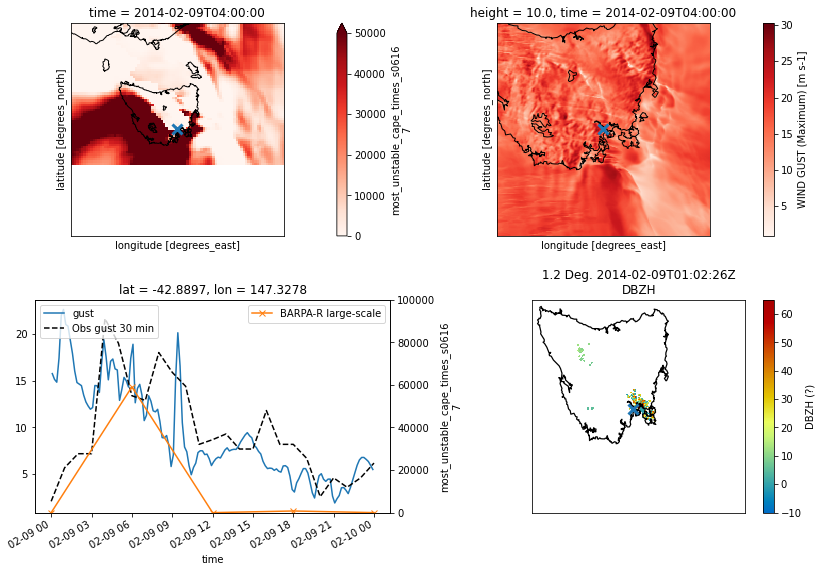

In [29]:
ind=-3
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_obs.reset_index().level_0.values)[ind], top_obs["lon"].iloc[ind], top_obs["lat"].iloc[ind], wg_obs, wg_daily, top_obs.reset_index().level_1.values[ind], time_max="obs")        
        
rllbox = 5; cllbox = 2;
rdomain = [top_obs["lat"].iloc[ind]-rllbox, top_obs["lat"].iloc[ind]+rllbox, top_obs["lon"].iloc[ind]-rllbox, top_obs["lon"].iloc[ind]+rllbox]
cdomain = [top_obs["lat"].iloc[ind]-cllbox, top_obs["lat"].iloc[ind]+cllbox, top_obs["lon"].iloc[ind]-cllbox, top_obs["lon"].iloc[ind]+cllbox]

rid="37"; rsweep=1; radar_t_delta=0
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_obs["lat"].iloc[ind], top_obs["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,100000],rvar_cbar_lims=[0,50000])

2009-01-22 00:00:00 147.3278 -42.8897
INFO: LOADING RADAR FILE FOR ID 37 AND TIME 20090122


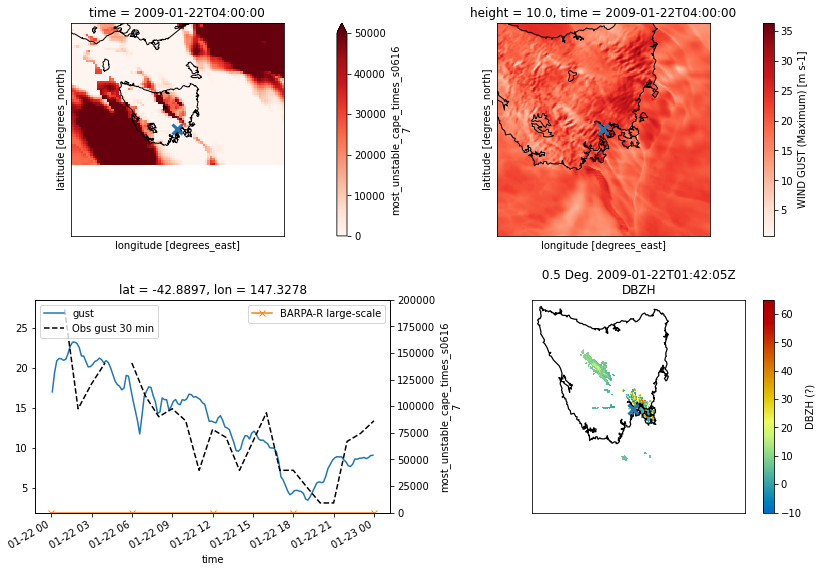

In [56]:
ind=-4
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_obs.reset_index().level_0.values)[ind], top_obs["lon"].iloc[ind], top_obs["lat"].iloc[ind], wg_obs, wg_daily, top_obs.reset_index().level_1.values[ind], time_max="obs", model_delta_t=240)        
        
rllbox = 5; cllbox = 2;
rdomain = [top_obs["lat"].iloc[ind]-rllbox, top_obs["lat"].iloc[ind]+rllbox, top_obs["lon"].iloc[ind]-rllbox, top_obs["lon"].iloc[ind]+rllbox]
cdomain = [top_obs["lat"].iloc[ind]-cllbox, top_obs["lat"].iloc[ind]+cllbox, top_obs["lon"].iloc[ind]-cllbox, top_obs["lon"].iloc[ind]+cllbox]

rid="37"; rsweep=0; radar_t_delta=0
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_obs["lat"].iloc[ind], top_obs["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=True,radar_t_delta=radar_t_delta,rvar_lims=[0,200000],rvar_cbar_lims=[0,50000])

1995-01-01 00:00:00 145.8294 -31.484


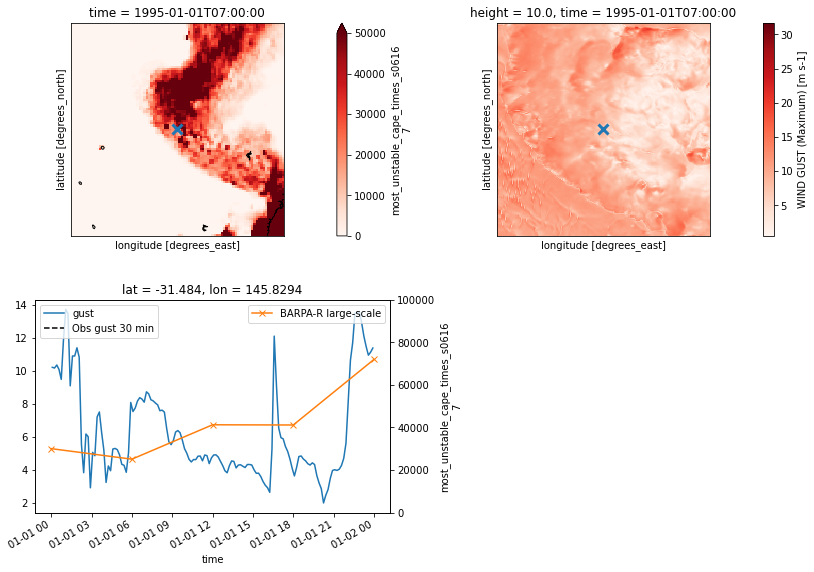

In [45]:
ind=-5
ts,wg_map,reg,reg_ts,wg_loc = open_wgfile(pd.DatetimeIndex(top_obs.reset_index().level_0.values)[ind], top_obs["lon"].iloc[ind], top_obs["lat"].iloc[ind], wg_obs, wg_daily, top_obs.reset_index().level_1.values[ind], time_max="obs")        
        
rllbox = 5; cllbox = 2;
rdomain = [top_obs["lat"].iloc[ind]-rllbox, top_obs["lat"].iloc[ind]+rllbox, top_obs["lon"].iloc[ind]-rllbox, top_obs["lon"].iloc[ind]+rllbox]
cdomain = [top_obs["lat"].iloc[ind]-cllbox, top_obs["lat"].iloc[ind]+cllbox, top_obs["lon"].iloc[ind]-cllbox, top_obs["lon"].iloc[ind]+cllbox]

rid="02"; rsweep=1; radar_t_delta=180
plot(reg, reg_ts, wg_map, ts, "mucape*s06", rdomain, cdomain, top_obs["lat"].iloc[ind], top_obs["lon"].iloc[ind], wg_loc, rid=rid,rsweep=rsweep,radar=False,radar_t_delta=radar_t_delta,rvar_lims=[0,100000],rvar_cbar_lims=[0,50000])